# Base BERT multi-label classification

### 1 Dependencies

In [ ]:
#!pip install torch transformers pandas numpy scikit-learn fastparquet

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score,
    f1_score, accuracy_score
)

import ast

### 2 Seeds and Device

In [3]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3 Dataset for manipulating techniques

In [4]:
class ManipulationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, techniques, tokenizer, max_len=512):
        self.texts = texts
        self.techniques = techniques
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Create label encoder
        self.unique_techniques = sorted(list(set(
            technique
            for techniques_list in self.techniques
            for technique in (ast.literal_eval(techniques_list) if isinstance(techniques_list, str)
                                                                else techniques_list.tolist()
                                                                if hasattr(techniques_list, 'tolist')
                                                                else techniques_list or [])
        )))
        self.technique_to_idx = {technique: idx for idx, technique in enumerate(self.unique_techniques)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])

        # Convert techniques to multi-hot encoding
        techniques = self.techniques[item]
        if isinstance(techniques, str):
            techniques = ast.literal_eval(techniques)

        label = torch.zeros(len(self.unique_techniques))
        if techniques is not None and len(techniques) > 0:
            for technique in techniques:
                label[self.technique_to_idx[technique]] = 1

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

### 4 Load Dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

df = pd.read_parquet('/content/techniques-classification.parquet')

train_df, val_df = train_test_split(df, test_size=0.2)

train_dataset = ManipulationDataset(train_df['content'].values, train_df['techniques'].values, tokenizer)
val_dataset = ManipulationDataset(val_df['content'].values, val_df['techniques'].values, tokenizer)

### 5 Model preparation

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5

    precision = precision_score(labels, preds, average='micro')
    recall = recall_score(labels, preds, average='micro')
    f1 = f1_score(labels, preds, average='micro')
    accuracy = accuracy_score(labels, preds)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=len(train_dataset.unique_techniques),
    problem_type="multi_label_classification"
).to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='logs',
    num_train_epochs=13,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,
    logging_steps=100
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

### 6 Train Model

In [9]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yarinko-b (yarinko-bohdan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.326700,0.292742,0.680851,0.292981,0.409673,0.362092
2,0.306300,0.298356,0.623711,0.369278,0.463898,0.360784
3,0.259000,0.290910,0.713911,0.276704,0.398827,0.403922
4,0.238900,0.294692,0.706366,0.349949,0.468027,0.413072
5,0.226200,0.290454,0.636914,0.428281,0.512165,0.389542
6,0.183200,0.304493,0.648829,0.394710,0.490829,0.392157
7,0.160500,0.316767,0.628800,0.399797,0.488806,0.385621
8,0.146300,0.338991,0.642276,0.401831,0.494368,0.394771
9,0.123000,0.355319,0.577259,0.402848,0.474536,0.375163
10,0.095600,0.374994,0.609281,0.414039,0.493035,0.380392


TrainOutput(global_step=4979, training_loss=0.1745154047902987, metrics={'train_runtime': 5216.1048, 'train_samples_per_second': 7.619, 'train_steps_per_second': 0.955, 'total_flos': 1.0457047513995264e+16, 'train_loss': 0.1745154047902987, 'epoch': 13.0})

In [10]:
evaluation_feedback = trainer.evaluate()

### 7 Save Model

In [11]:
trainer.save_model("models")
tokenizer.save_pretrained("models")


('models/tokenizer_config.json',
 'models/special_tokens_map.json',
 'models/vocab.txt',
 'models/added_tokens.json',
 'models/tokenizer.json')

### 8 Metrics Visualisation

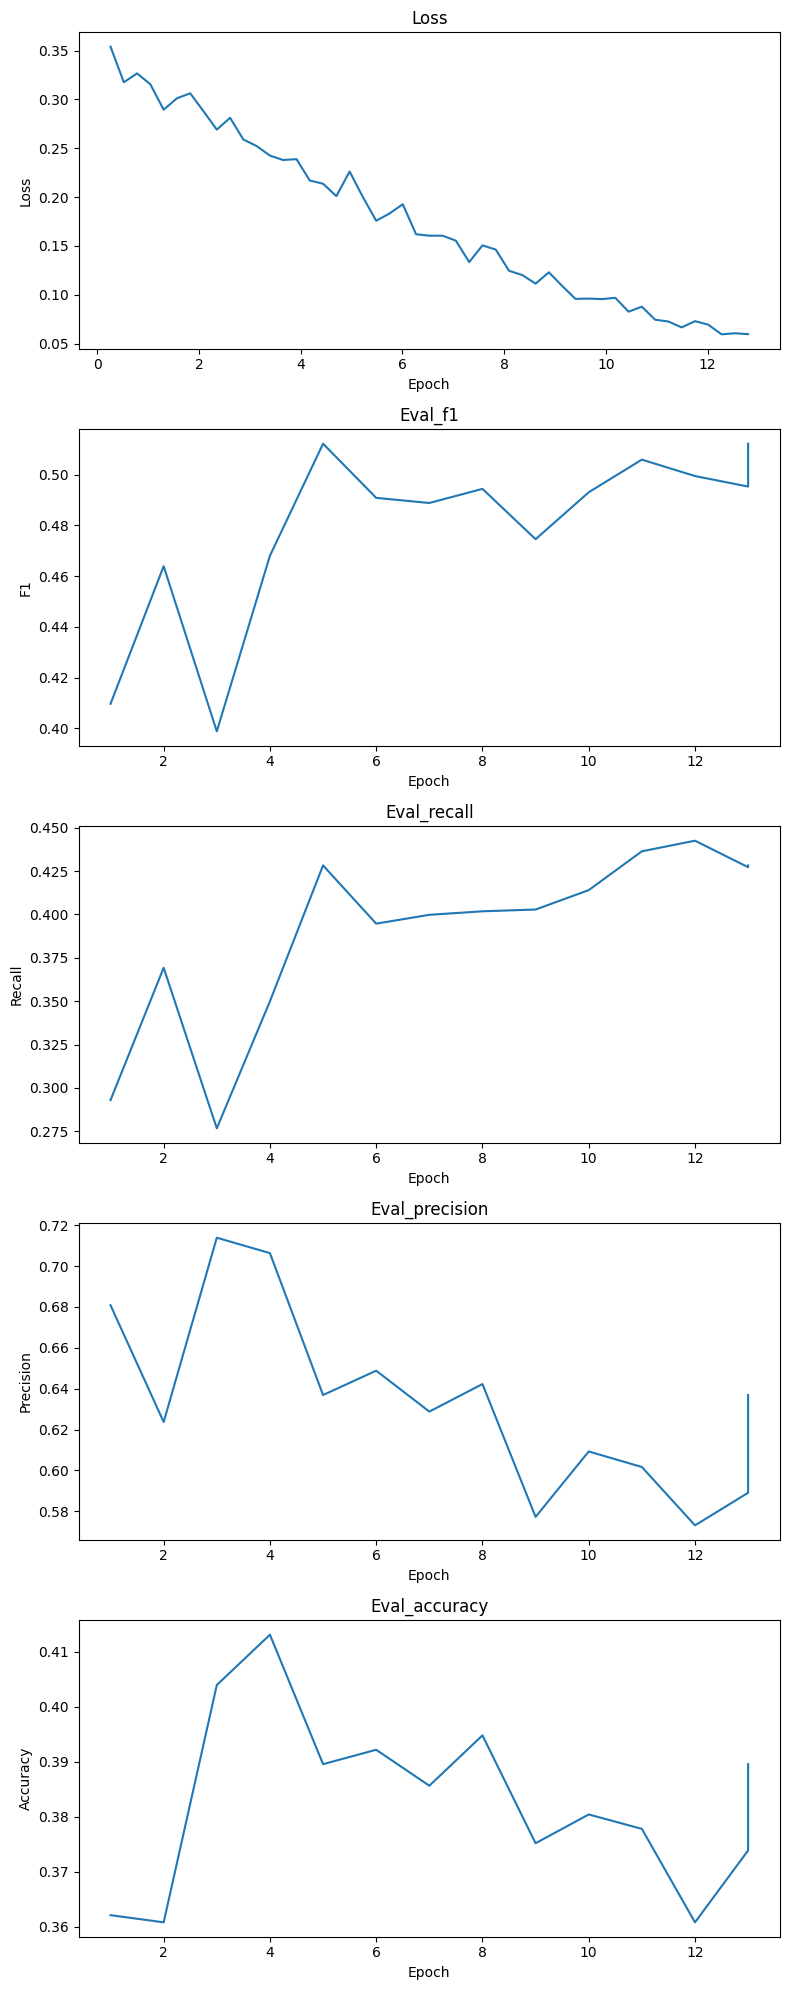

In [19]:
logs = trainer.state.log_history

# Metrics with corresponding epochs
metrics = ['loss', 'eval_f1', 'eval_recall', 'eval_precision', 'eval_accuracy']
data = {}
for metric in metrics:
    data[metric] = {'values': [], 'epochs': []}
    for log in logs:
        if metric in log:
            data[metric]['values'].append(log[metric])
            data[metric]['epochs'].append(log['epoch'])

# Plots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 4 * len(metrics)))

for i, metric in enumerate(metrics):
    axes[i].plot(data[metric]['epochs'], data[metric]['values'])
    axes[i].set_title(metric.capitalize())
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric.replace('eval_', '').capitalize())

plt.tight_layout()
plt.show()

### 9 Test

In [35]:
def predict(text, model, tokenizer, unique_techniques):
    model.eval()
    model.to(device)
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(encoding['input_ids'], encoding['attention_mask']).logits
        predictions = torch.sigmoid(outputs) > 0.5

    predicted_techniques = [unique_techniques[i] for i, pred in enumerate(predictions[0]) if pred]
    return predicted_techniques

In [36]:
model = AutoModelForSequenceClassification.from_pretrained("/content/models")
tokenizer = AutoTokenizer.from_pretrained("/content/models")

text_to_predict = "Уничтожение ВСУшников в Бахмуте артиллерией «Вагнер»"

unique_techniques = train_dataset.unique_techniques
predicted_techniques = predict(text_to_predict, model, tokenizer, unique_techniques)
predicted_techniques

['loaded_language']